<a href="https://colab.research.google.com/github/Ramkanc/Capstone_IIITH/blob/Capstone1_MultiModel_V1/Capstone1_RamK_Multi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install opencv-python==4.8.0.76

In [1]:
# Import Libraries
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F

from torchsummary import summary
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.datasets import ImageFolder

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
import pandas as pd

In [2]:
import PIL
from PIL import Image

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


In [5]:
found_directories = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
found_files =[f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
print (found_directories)
print (found_files)

['Images']
['captions.txt']


In [6]:
image_dir= os.path.join(path, found_directories[0])
print(image_dir)

/root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/Images


In [7]:
# Define a custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, image_dir):
        """
        Args:
            image_dir (str): Path to the directory with images.
        """
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('jpg', 'png', 'jpeg'))]

    def preprocess_image_opencv(self, image_path):
        # Read the image using OpenCV
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Image not found at {image_path}")

        # Resize to 224x224
        image_resized = cv2.resize(image, (224, 224))

        # Convert from BGR to RGB
        image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)

        # Normalize pixel values to [0, 1]
        image_normalized = image_rgb / 255.0

        # Reshape to CxHxW
        image_reshaped = np.transpose(image_normalized, (2, 0, 1))

        # Convert to PyTorch tensor
        image_tensor = torch.tensor(image_reshaped, dtype=torch.float32)

        # Normalize using ImageNet mean and std
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image_tensor = (image_tensor - mean) / std

        return image_tensor

    def __len__(self):
        # Return the number of images
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get the image path
        image_file_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file_name)

        # Preprocess the image
        image_tensor = self.preprocess_image_opencv(image_path)

        # Extract image ID (filename without extension)
        image_id = os.path.splitext(image_file_name)[0]

        # Return the processed tensor
        return image_tensor,image_id

In [8]:
# Create an instance of the custom dataset
dataset = CustomImageDataset(image_dir)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [9]:
# Iterate over the DataLoader
for batch_idx, (batch_images, image_ids) in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Shape: {batch_images.shape}")  # Expected: [batch_size, 3, 224, 224]
    print(f"Type: {batch_images.dtype}")  # Expected: torch.float32
    print(f"Image IDs: {image_ids}")  # Print the image IDs in the batch
    break

Batch 1:
Shape: torch.Size([32, 3, 224, 224])
Type: torch.float32
Image IDs: ('3411595210_8e0893b266', '2894229082_ddc395f138', '3014986976_0e7b858970', '2384147448_c1869070d3', '979383193_0a542a059d', '3270691950_88583c3524', '2932498509_27cb0038ec', '3042483842_beb23828b9', '811663364_4b350a62ce', '3604391853_b4809fcb8c', '2313822078_282dc07531', '2091171488_c8512fec76', '2806710650_e201acd913', '427082246_5bf1c3676f', '3362189985_fbae8f860a', '3258394043_a0b6a94dce', '3725353555_75c346d7ec', '2873837796_543e415e98', '3015898903_70bebb8903', '448252603_7d928c900e', '2256133102_e2c8314ecb', '2098174172_e57d86ea03', '1446053356_a924b4893f', '2062607137_dac194ad02', '3546720729_38fff1bbd9', '1650280501_29810b46e5', '3599568766_9e96def0ef', '207930963_af3a2f1784', '2500567791_101d5ddee3', '1683444418_815f660379', '3537920947_6c5a956f47', '3556571710_19cee6f5bd')


In [10]:
# Function to display a single image
def show_image(image_tensor):
    # Undo normalization for display (optional if you want raw pixel values)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image_tensor = image_tensor * std + mean  # Denormalize

    # Convert from Tensor (CxHxW) to NumPy array (HxWxC)
    image_numpy = image_tensor.permute(1, 2, 0).numpy()
    image_numpy = np.clip(image_numpy, 0, 1)  # Clip values to [0, 1] for proper display

    # Display the image
    plt.imshow(image_numpy)
    plt.axis('off')

In [11]:
def display_images_from_dataloader(dataloader, num_images=10):
    images_shown = 0
    plt.figure(figsize=(15, 10))  # Adjust figure size for better visualization

    for batch_idx, (batch_images, image_ids) in enumerate(dataloader):
        for image_idx, image_tensor in enumerate(batch_images):
            if images_shown >= num_images:
                break

            # Get the image ID for the current image
            image_id = image_ids[image_idx]

            plt.subplot(2, 5, images_shown + 1)  # Create a 2x5 grid for 10 images
            show_image(image_tensor)
            plt.title(image_id)  # Set the image ID as the title
            images_shown += 1

        if images_shown >= num_images:
            break

    plt.tight_layout()
    plt.show()

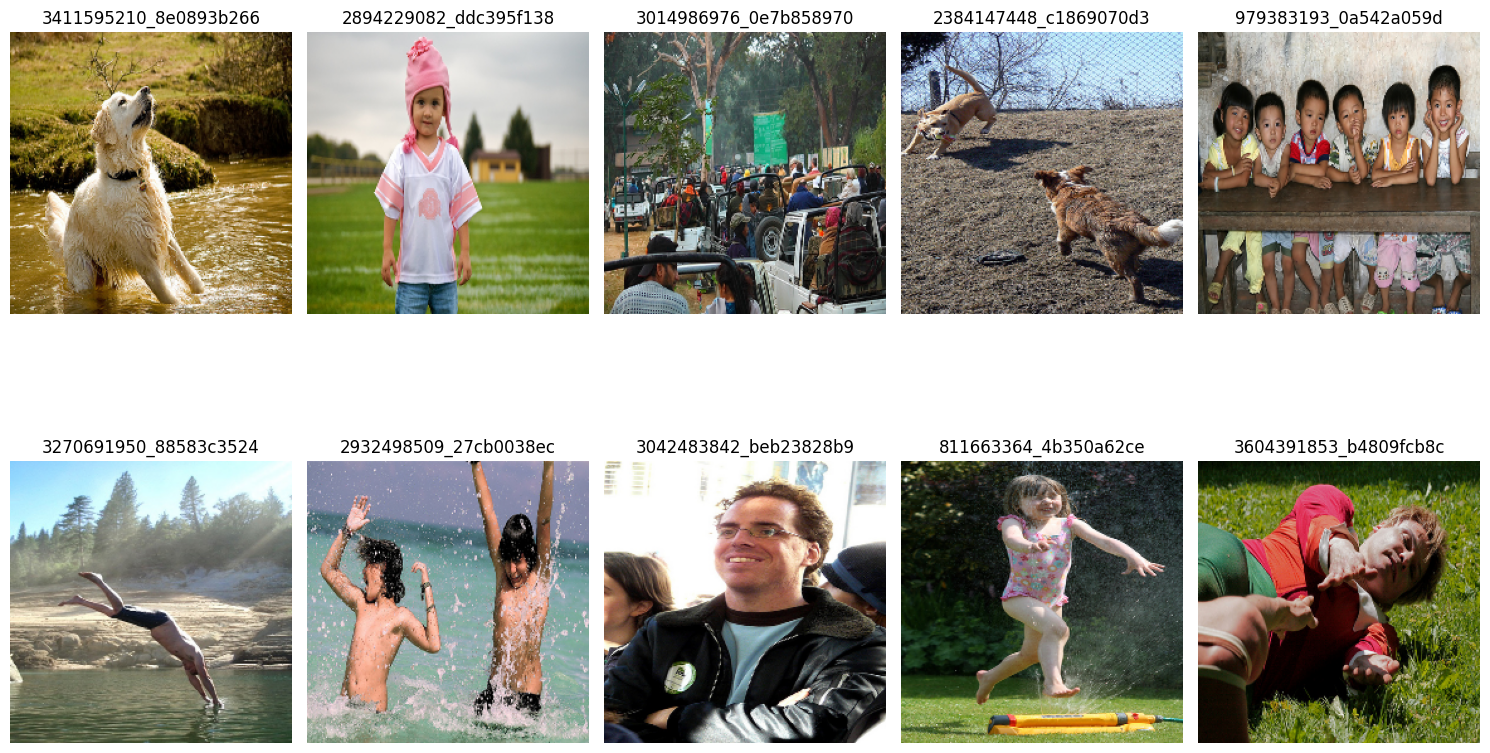

In [12]:
# Call the function to display images
display_images_from_dataloader(dataloader,num_images=10)

In [13]:
labels_file = os.path.join(path, found_files[0])

In [14]:
# for line in open(labels_file, 'r'):
#     print(line)

In [15]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_colwidth', None) # Show full column width

In [16]:
raw_captions = pd.read_csv(labels_file, delimiter=',',header=0)

In [17]:
raw_captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .


In [18]:
concatenated_df= raw_captions.groupby('image')['caption'].apply(lambda x: ' '.join(x.astype(str))).reset_index()

In [19]:
concatenated_df.head(2)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way . A girl going into a wooden building . A little girl climbing into a wooden playhouse . A little girl climbing the stairs to her playhouse . A little girl in a pink dress going into a wooden cabin .
1,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting A black dog and a tri-colored dog playing with each other on the road . A black dog and a white dog with brown spots are staring at each other in the street . Two dogs of different breeds looking at each other on the road . Two dogs on pavement moving toward each other .


In [20]:
concatenated_df['caption_word_count'] = concatenated_df['caption'].apply(lambda x: len(x.split()))

In [21]:
concatenated_df['image'] = concatenated_df['image'].str.replace('.jpg', '', regex=False)

In [22]:
concatenated_df.head()

,image,caption,caption_word_count
0,1000268201_693b08cb0e,A child in a pink dress is climbing up a set of stairs in an entry way . A girl going into a wooden building . A little girl climbing into a wooden playhouse . A little girl climbing the stairs to her playhouse . A little girl in a pink dress going into a wooden cabin .,58
1,1001773457_577c3a7d70,A black dog and a spotted dog are fighting A black dog and a tri-colored dog playing with each other on the road . A black dog and a white dog with brown spots are staring at each other in the street . Two dogs of different breeds looking at each other on the road . Two dogs on pavement moving toward each other .,65
2,1002674143_1b742ab4b8,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl . A little girl is sitting in front of a large painted rainbow . A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it . There is a girl with pigtails sitting in front of a rainbow painting . Young girl with pigtails painting outside in the grass .,78
3,1003163366_44323f5815,A man lays on a bench while his dog sits by him . A man lays on the bench to which a white dog is also tied . a man sleeping on a bench outside with a white and black dog sitting next to him . A shirtless man lies on a park bench with his dog . man laying on bench holding leash of dog sitting on ground,69
4,1007129816_e794419615,A man in an orange hat starring at something . A man wears an orange hat and glasses . A man with gauges and glasses is wearing a Blitz hat . A man with glasses is wearing a beer can crocheted hat . The man with pierced ears is wearing glasses and an orange hat .,56


In [23]:
max_word_count = concatenated_df['caption_word_count'].max()
print("Maximum caption word count:", max_word_count)

Maximum caption word count: 104


In [24]:
from transformers import BertTokenizer
import re

In [25]:
def preprocess_caption(caption):
    """Preprocesses the caption text.

    Args:
        caption (str): The caption text.

    Returns:
        str: The preprocessed caption text.
    """
    # Lowercase the text
    caption = caption.lower()

    # Remove punctuation (fixed regex for removing special characters)
    caption = re.sub(r"[^a-zA-Z0-9 ]", "", caption)

    # Add special tokens for start and end of sequence (if needed by your model)
    # caption = "[CLS] " + caption + " [SEP]"  # Example for BERT

    return caption

In [26]:
def tokenize_caption(caption, tokenizer, max_length=32):
    """Tokenizes the preprocessed caption text.

    Args:
        caption (str): The preprocessed caption text.
        tokenizer (transformers.BertTokenizer): The tokenizer object.
        max_length (int): Maximum length for tokenized captions.

    Returns:
        tuple: A tuple containing token IDs and attention mask.
    """
    inputs = tokenizer(
        caption,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    return inputs["input_ids"].squeeze(0), inputs["attention_mask"].squeeze(0)

In [27]:
class CaptionsDataset(Dataset):
    def __init__(self, captions_df, tokenizer, max_length=104):
        self.captions_df = captions_df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.captions_df)

    def __getitem__(self, idx):
        item = self.captions_df.iloc[idx]
        image_id = item['image']  # Get image ID (filename without extension)
        caption = item['caption']

        # Preprocess and tokenize the caption
        preprocessed_caption = preprocess_caption(caption)
        token_ids, attention_mask = tokenize_caption(preprocessed_caption, self.tokenizer, self.max_length)

        return token_ids, attention_mask, image_id

In [28]:
# Create a BertTokenizer instance
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [29]:
# Create the CaptionsDataset
captions_dataset = CaptionsDataset(concatenated_df, tokenizer, max_length=104)  # Adjust max_length as needed

In [30]:
# Create the DataLoader
captions_dataloader = DataLoader(captions_dataset, batch_size=32, shuffle=False)  # Adjust batch_size as needed

In [31]:
count = 0  # Initialize a counter
for batch in captions_dataloader:
    for i in range(len(batch[0])):  # Iterate through items in the batch
        if count >= 10:
            break

        image_id = batch[2][i]
        token_ids = batch[0][i].tolist()  # Convert token_ids tensor to list
        tokens = tokenizer.convert_ids_to_tokens(token_ids)  # Convert token_ids to tokens

        print(f"Image ID: {image_id}")
        print(f"Token IDs: {token_ids}")
        print(f"Tokens: {tokens}")
        print("-" * 20)  # Separator

        count += 1  # Increment the counter

    if count >= 10:
        break

Image ID: 1000268201_693b08cb0e
Token IDs: [101, 1037, 2775, 1999, 1037, 5061, 4377, 2003, 8218, 2039, 1037, 2275, 1997, 5108, 1999, 2019, 4443, 2126, 1037, 2611, 2183, 2046, 1037, 4799, 2311, 1037, 2210, 2611, 8218, 2046, 1037, 4799, 17408, 1037, 2210, 2611, 8218, 1996, 5108, 2000, 2014, 17408, 1037, 2210, 2611, 1999, 1037, 5061, 4377, 2183, 2046, 1037, 4799, 6644, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokens: ['[CLS]', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'a', 'girl', 'going', 'into', 'a', 'wooden', 'building', 'a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', 'a', 'little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her', 'playhouse', 'a', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'going', 'into', 'a', 'wooden', 'cabin', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [57]:
# # prompt: provide code to use pretrained VGG16 by excluding the classifier and add a layer to output 1D size of 256

# # Load pre-trained VGG16 model without the classifier
# vgg16 = models.vgg16(pretrained=True)
# vgg16 = nn.Sequential(*list(vgg16.children())[:-1]) # Remove the classifier layers

# # Freeze the parameters of the pre-trained layers
# for param in vgg16.parameters():
#     param.requires_grad = False

# # Add a custom classifier with a 1D output of size 256
# class CustomClassifier(nn.Module):
#     def __init__(self):
#         super(CustomClassifier, self).__init__()
#         self.fc = nn.Linear(512 * 7 * 7, 256) # Adjust input size if you change the VGG architecture

#     def forward(self, x):
#         x = torch.flatten(x, 1)
#         x = self.fc(x)
#         return x

# custom_classifier = CustomClassifier()

# # Combine the VGG16 feature extractor and the custom classifier
# model = nn.Sequential(vgg16, custom_classifier)
# model = model.to(device)

# # Print the model summary (optional)
# summary(model, (3, 224, 224)) # input size should be adjusted according to dataset

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [37]:
class ImageEncoder(nn.Module):
    def __init__(self, embedding_size=256):  # adjust the embedding_size
        super(ImageEncoder, self).__init__()
        # Load pre-trained VGG16 model
        #vgg16 = models.vgg16(pretrained=True)
        #model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

        # Remove the classification layer (last layer)
        #modules = list(vgg16.children())[:-1]
        modules = list(model.children())[:-1]

        # Create the feature extractor
        self.vgg16 = nn.Sequential(*modules)

        # Freeze the VGG16 parameters (optional)
        for param in self.vgg16.parameters():
            param.requires_grad = False

        # Add a linear layer to project to desired embedding size
        self.embedding_layer = nn.Linear(512 * 7 * 7, embedding_size)

#)

    def forward(self, images):
        features = self.vgg16(images)  # Extract features using VGG16
        features = features.view(features.size(0), -1)  # Flatten the features
        embeddings = self.embedding_layer(features)# Project to embedding space
        #embeddings = F.normalize(embeddings, p=2, dim=1)  # Normalize embeddings
        #embeddings = embeddings.flatten()
        return embeddings

    def process_dataloader(self, image_dataloader, device):
        all_embeddings = []
        all_image_ids = []
        for batch_idx, (images, image_ids) in enumerate(image_dataloader):
            # Move images to the appropriate device
            images = images.to(device)

            # Generate embeddings for the batch
            with torch.no_grad():  # Disable gradient calculation for inference
                batch_embeddings = self.forward(images)

            # Append embeddings to the list
            all_embeddings.append(batch_embeddings)
            all_image_ids.extend(image_ids)  # Extend the list with image IDs

        # Concatenate all embeddings
        all_embeddings = torch.cat(all_embeddings, dim=0)
        return all_embeddings, all_image_ids

In [38]:
# Create an instance of the ImageEncoder
image_encoder = ImageEncoder(embedding_size=256).to(device)  # Move model to the device

In [39]:
print(summary(image_encoder, (3, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [40]:
# Process the image dataloader and get embeddings
image_embeddings, image_ids = image_encoder.process_dataloader(dataloader, device)

In [42]:
# Print the shape and type of image embeddings
print(f"Image embeddings shape: {image_embeddings.shape}")
print(f"Image embeddings type: {image_embeddings.dtype}")
print(f"Number of image IDs: {len(image_ids)}")

Image embeddings shape: torch.Size([8091, 256])
Image embeddings type: torch.float32
Number of image IDs: 8091


In [43]:
#from collections import Counter
# # Assuming 'captions' is a list of all captions in your training data
# word_counts = Counter([word for caption in captions for word in caption.split()])

# # Set a threshold frequency
# threshold = 5

# # Create vocabulary
# vocabulary = [word for word, count in word_counts.items() if count >= threshold]

# # Add special tokens
# vocabulary = ['<PAD>', '<START>', '<END>', '<UNK>'] + vocabulary

# # Calculate vocab_size
# vocab_size = len(vocabulary)

In [44]:
class CaptionEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1):
        super(CaptionEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)

    def forward(self, captions):
        embeddings = self.embedding(captions)  # Embed the captions
        _, (hidden, _) = self.lstm(embeddings)  # Pass through LSTM
        return hidden[-1]  # Return the last hidden state as the caption embedding

    def process_dataloader(self, captions_dataloader, device):
        all_embeddings = []
        all_image_ids = []
        for batch_idx, (token_ids, attention_masks, image_ids) in enumerate(captions_dataloader):
            # Move data to the appropriate device
            token_ids = token_ids.to(device)

            # Generate embeddings for the batch
            batch_embeddings = self.forward(token_ids)

            # Append embeddings to the list
            all_embeddings.append(batch_embeddings)
            all_image_ids.extend(image_ids)

        # Concatenate all embeddings
        all_embeddings = torch.cat(all_embeddings, dim=0)
        return all_embeddings, all_image_ids

In [45]:
vocab_size = tokenizer.vocab_size # Example vocabulary size
embedding_dim = 256  # Example embedding dimension
hidden_dim = 512  # Example hidden dimension

In [46]:
caption_encoder = CaptionEncoder(vocab_size, embedding_dim, hidden_dim).to(device)

In [47]:
caption_embeddings, caption_image_ids = caption_encoder.process_dataloader(captions_dataloader, device)

In [48]:
print(f"Caption embeddings shape: {caption_embeddings.shape}")
print(f"Caption embeddings type: {caption_embeddings.dtype}")
print(f"Number of caption IDs: {len(caption_image_ids)}")

Caption embeddings shape: torch.Size([8091, 512])
Caption embeddings type: torch.float32
Number of caption IDs: 8091


In [51]:
# 1. Create training data pairs (image_embedding, caption_embedding)
image_embeddings_dict = {image_id: embedding for image_id, embedding in zip(image_ids, image_embeddings)}
training_data = []
for i, caption_image_id in enumerate(caption_image_ids):
    image_embedding = image_embeddings_dict[caption_image_id]
    caption_embedding = caption_embeddings[i]
    training_data.append((image_embedding, caption_embedding))

In [52]:
print (f"Number of training data pairs: {len(training_data)}")
#print (f"First training data pair: {training_data[0]}")
print (f"First training data type:", type(training_data[0]))
print (f"First training data length:", len(training_data[0]))
print (f"First training data type:", type(training_data[0][0]))
print (f"First training data type:", type(training_data[0][1]))
print (f"First training data type:", training_data[0][0].shape)
print (f"First training data type:", training_data[0][1].shape)

Number of training data pairs: 8091
First training data type: <class 'tuple'>
First training data length: 2
First training data type: <class 'torch.Tensor'>
First training data type: <class 'torch.Tensor'>
First training data type: torch.Size([256])
First training data type: torch.Size([512])


In [53]:
# 2. Create dataset and data loader for training
class ImageCaptionDataset(Dataset):
    def __init__(self, training_data):
        self.training_data = training_data

    def __len__(self):
        return len(self.training_data)

    def __getitem__(self, idx):
        image_embedding, caption_embedding = self.training_data[idx]
        return image_embedding, caption_embedding

In [54]:
# Create dataset instance
image_caption_dataset = ImageCaptionDataset(training_data)

In [64]:
# Create data loader
train_dataloader = DataLoader(image_caption_dataset, batch_size=32, shuffle=False)

In [65]:
# 3.1 Define the DecoderWithAttention (incorporating attention)
class DecoderWithAttention(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, num_layers=1):
        super(DecoderWithAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim + hidden_dim, hidden_dim, num_layers, batch_first=True) # combined embedding + attention context
        self.fc = nn.Linear(hidden_dim, vocab_size)

        # Attention layers
        self.attention_layer = nn.Linear(hidden_dim, hidden_dim)  # Used to project decoder hidden state

    def forward(self, combined_embeddings, captions, image_embeddings):
        # Embed captions
        embedded_captions = self.embedding(captions)

        # Initialize hidden and cell states (you might need to adjust this)
        hidden = combined_embeddings.unsqueeze(0)
        cell = torch.zeros_like(hidden)

        # Store outputs
        outputs = []

        for i in range(captions.shape[1]):  # Iterate over caption length
            # Calculate attention weights
            attention_weights = torch.softmax(
                torch.bmm(self.attention_layer(hidden[0]), image_embeddings.transpose(1, 2)), dim=1)

            # Calculate attention context
            context_vector = torch.bmm(attention_weights, image_embeddings)

            # Concatenate context with embedded caption word
            lstm_input = torch.cat([embedded_captions[:, i:i+1, :], context_vector], dim=2)

            # Pass through LSTM
            output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))

            # Pass through linear layer to get word probabilities
            output = self.fc(output)

            # Append to outputs
            outputs.append(output)

        # Stack outputs to get the final prediction sequence
        outputs = torch.cat(outputs, dim=1)

        return outputs

In [66]:
# 3. Define the ImageCaptioningModel (with projection layers)
# class ImageCaptioningModel(nn.Module):
#     def __init__(self, image_encoder, caption_encoder, decoder, shared_embedding_dim=256):
#         super(ImageCaptioningModel, self).__init__()
#         self.image_encoder = image_encoder
#         self.caption_encoder = caption_encoder
#         self.decoder = decoder

#         # Projection layers
#         self.image_projection = nn.Linear(image_encoder.embedding_layer.out_features, shared_embedding_dim)
#         self.caption_projection = nn.Linear(caption_encoder.lstm.hidden_size, shared_embedding_dim)

#     def forward(self, images, captions):
#         # Get image and caption embeddings
#         image_embeddings = self.image_encoder(images)
#         caption_embeddings = self.caption_encoder(captions)

#         # Project to shared embedding space
#         projected_image_embeddings = self.image_projection(image_embeddings)
#         projected_caption_embeddings = self.caption_projection(caption_embeddings)

#         # Combine image and caption embeddings
#         combined_embeddings = torch.cat([projected_image_embeddings, projected_caption_embeddings], dim=1)

#         # Pass through decoder
#         outputs = self.decoder(combined_embeddings, captions)  # Pass combined embeddings to the decoder
#         return outputs

In [77]:
# 3. Define the ImageCaptioningModel (with projection layers)
import torch
import torch.nn as nn
from torchvision import models

class ImageCaptionModel(nn.Module):
    def __init__(self, embedding_dim=256, hidden_dim=512, vocab_size=30522):
        super(ImageCaptionModel, self).__init__()

        # 1. Feature Extraction
        self.feature_extractor = models.vgg16(pretrained=True)
        modules = list(self.feature_extractor.children())[:-1]
        self.feature_extractor = nn.Sequential(*modules)
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        self.feature_projection = nn.Linear(512 * 7 * 7, embedding_dim)

        # 2. LSTM Decoder with Attention
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.attention_layer = nn.Linear(hidden_dim, hidden_dim)
        self.lstm = nn.LSTM(embedding_dim + hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, image_features, captions):
        # 1. Project image features to embedding space
        # Reshape image_features before passing to feature_extractor
        # Assuming image_features shape is [batch_size, channels, height, width]
        # You might need to adjust the reshape dimensions based on your actual image size
        batch_size, channels, height, width = image_features.shape
        image_features = image_features.reshape(batch_size, channels, height, width) # Reshape to 4D for conv2d

        image_features = self.feature_extractor(image_features)
        image_features = self.adaptive_pool(image_features)
        image_features = image_features.reshape(image_features.size(0), -1)
        projected_image_features = self.feature_projection(image_features)

        # 2. Embed captions
        embedded_captions = self.embedding(captions)

        # 3. Initialize hidden and cell states
        batch_size = image_features.size(0)
        hidden = projected_image_features.unsqueeze(0).repeat(self.lstm.num_layers, 1, 1)
        cell = torch.zeros_like(hidden)

        # 4. Iterate over caption length (decoding)
        outputs = []
        for i in range(captions.shape[1]):
            attention_weights = torch.softmax(
                torch.bmm(self.attention_layer(hidden[0]), projected_image_features.unsqueeze(1).transpose(1, 2)), dim=2)

            context_vector = torch.bmm(attention_weights, projected_image_features.unsqueeze(1))
            context_vector = context_vector.squeeze(1)

            lstm_input = torch.cat([embedded_captions[:, i, :], context_vector], dim=1)
            lstm_input = lstm_input.unsqueeze(1)

            output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
            output = output.squeeze

In [78]:
# 4. Create model, optimizer, and loss function instances
decoder = DecoderWithAttention(embedding_dim=256, hidden_dim=512, vocab_size=tokenizer.vocab_size)  # Adjust dimensions if needed
#my_model = ImageCaptioningModel(image_encoder, caption_encoder, decoder, shared_embedding_dim=256).to(device)
my_model = ImageCaptionModel(embedding_dim=256, hidden_dim=512, vocab_size=tokenizer.vocab_size).to(device)
optimizer = torch.optim.Adam(my_model.parameters(), lr=0.001)
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [79]:
# 5. Define the training function (from previous responses)

def train_image_captioning_model(model, data_loader, optimizer, criterion, device, num_epochs):
    model.train()  # Set the model to training mode

    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0

        #for batch_idx, (images, captions, _) in enumerate(data_loader):
        for batch_idx, (images, captions) in enumerate(data_loader):
            images = images.to(device)
            captions = captions.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images, captions)

            # Calculate the loss (adjust target shape if needed)
            loss = criterion(outputs.view(-1, outputs.shape[-1]), captions.view(-1))

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

            # Print progress (optional)
            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(data_loader)}], Loss: {loss.item():.4f}")

        # Print epoch loss
        avg_epoch_loss = total_loss / num_batches
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_epoch_loss:.4f}")

    print("Training completed!")

In [80]:
# 6. Train the model
num_epochs = 10  # Adjust as needed
train_image_captioning_model(my_model, train_dataloader, optimizer, criterion, device, num_epochs)

ValueError: not enough values to unpack (expected 4, got 2)